In [3]:
# Import the necessary libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam # --> Optimierungsalgorithmus
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import keras_tuner as kt


# Define the file paths
subdirectory = "pickle_data_Croissant"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (1462, 25)
Loaded Validation features dimensions: (357, 25)
Loaded Test features dimensions: (355, 25)

Loaded Training labels dimensions: (1462, 1)
Loaded Validation labels dimensions: (357, 1)

First few rows of loaded training features:
      Temp_Very_Cold_current  Temp_Cold_current  Temp_Mild_current  \
3638                       0                  0                  1   
3639                       0                  0                  1   
3640                       0                  0                  0   
3641                       0                  0                  1   
3642                       0                  0                  1   

      Temp_Warm_current  Temp_Hot_current  Cloud_ok_current  \
3638                  0                 0                 0   
3639                  0                 0                 1   
3640                  1                 0                 0   
3641                  0                 0         

In [4]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(InputLayer(shape=(training_features.shape[1],)))
    
    # First dropout layer (fixed rate as in original)
    model.add(Dropout(0.1))
    
    # First dense layer with tunable units
    units1 = hp.Int('units1', min_value=32, max_value=128, step=16)
    model.add(Dense(units1, activation='relu', kernel_regularizer=l2(0.01)))
    
    # Second dense layer with tunable units
    units2 = hp.Int('units2', min_value=16, max_value=64, step=8)
    model.add(Dense(units2, activation='relu', kernel_regularizer=l2(0.01)))
    
    # Output layer
    model.add(Dense(1))
    
    # Tunable learning rate
    learning_rate = hp.Float(
        'learning_rate',
        min_value=1e-3,
        max_value=1e-2,
        sampling='log'
    )
    
    # Using AdamW optimizer with tunable learning rate
    model.compile(
        optimizer=Adam(
            learning_rate=learning_rate,
            beta_1=0.95,
            beta_2=0.95,
        ),
        loss='mse',
        metrics=['mape']
    )
    
    return model

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Add learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # Reduce LR by half when plateauing
    patience=3,         # Number of epochs with no improvement after which LR will be reduced
    min_lr=1e-6,       # Minimum LR value
    verbose=1          # Print message when reducing LR
)

# Initialize the RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=30,
    directory='keras_tuner/Croissant',
    project_name='nn_tuning',
    overwrite=True
)

# Search for the best hyperparameters
tuner.search(
    training_features,
    training_labels,
    epochs=100,
    validation_data=(validation_features, validation_labels),
    callbacks=[early_stopping, lr_scheduler],  # Added lr_scheduler to callbacks
    batch_size=24
)


Trial 30 Complete [00h 00m 12s]
val_mape: 18.646671295166016

Best val_mape So Far: 18.276132583618164
Total elapsed time: 00h 04m 59s


In [5]:
# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"Units in first dense layer: {best_hps.get('units1')}")
print(f"Units in second dense layer: {best_hps.get('units2')}")
print(f"learning rate: {best_hps.get('learning_rate')}")


Best Hyperparameters:
Units in first dense layer: 112
Units in second dense layer: 56
learning rate: 0.007955662951309572


In [6]:

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
history = model.fit(
    training_features,
    training_labels,
    epochs=100,
    batch_size=24,
    validation_data=(validation_features, validation_labels),
    callbacks=[early_stopping]
)


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 20847.5781 - mape: 73.1957 - val_loss: 1899.8025 - val_mape: 21.7531
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2932.1611 - mape: 25.5533 - val_loss: 1712.6997 - val_mape: 21.6950
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2310.6863 - mape: 22.9656 - val_loss: 1646.9417 - val_mape: 20.1774
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2297.1167 - mape: 21.5133 - val_loss: 1990.7142 - val_mape: 19.2461
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1921.7522 - mape: 20.9629 - val_loss: 1788.3608 - val_mape: 18.8654
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1887.8630 - mape: 21.1669 - val_loss: 1762.8448 - val_mape: 19.9243
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2003.2876 - mape: 20.9301 - val_loss: 2178.0977 - val_mape: 19.2658
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1808.3652 - mape: 19.9604 - val_loss: 2009.5359 - 

In [7]:
# Saving the trained Model
model.save("python_model_Croissant.h5")

In [8]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
MAPE on the Training Data: 19.24%
MAPE on the Validation Data: 20.18%


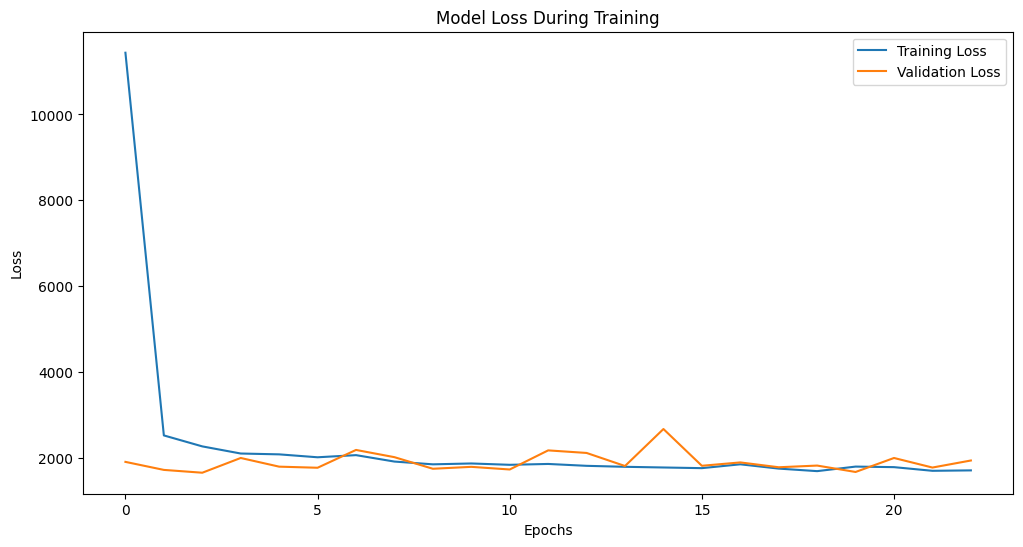

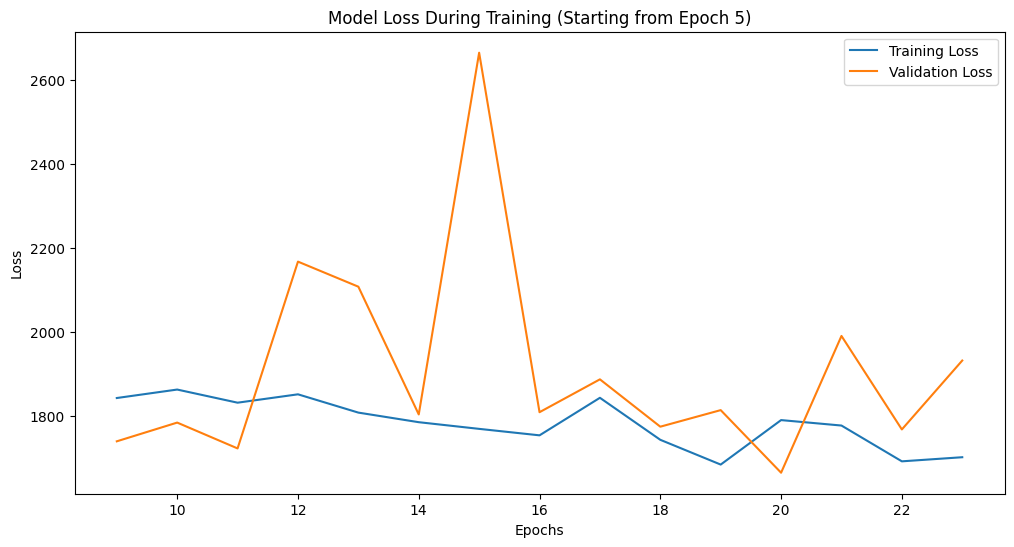

In [9]:
# Plotting Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training History (ab der 5. Epoche)
import matplotlib.pyplot as plt

# Schneide die Verlaufsdaten ab der 5. Epoche
epochs_to_plot = range(9, len(history.history['loss']) + 1)
training_loss = history.history['loss'][8:]
validation_loss = history.history['val_loss'][8:]

plt.figure(figsize=(12, 6))
plt.plot(epochs_to_plot, training_loss, label='Training Loss')
plt.plot(epochs_to_plot, validation_loss, label='Validation Loss')
plt.title('Model Loss During Training (Starting from Epoch 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


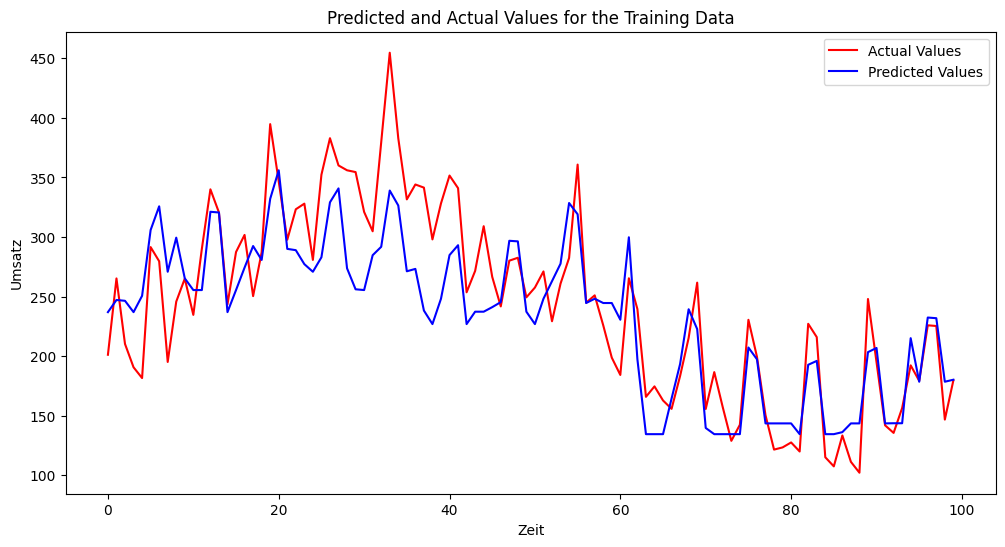

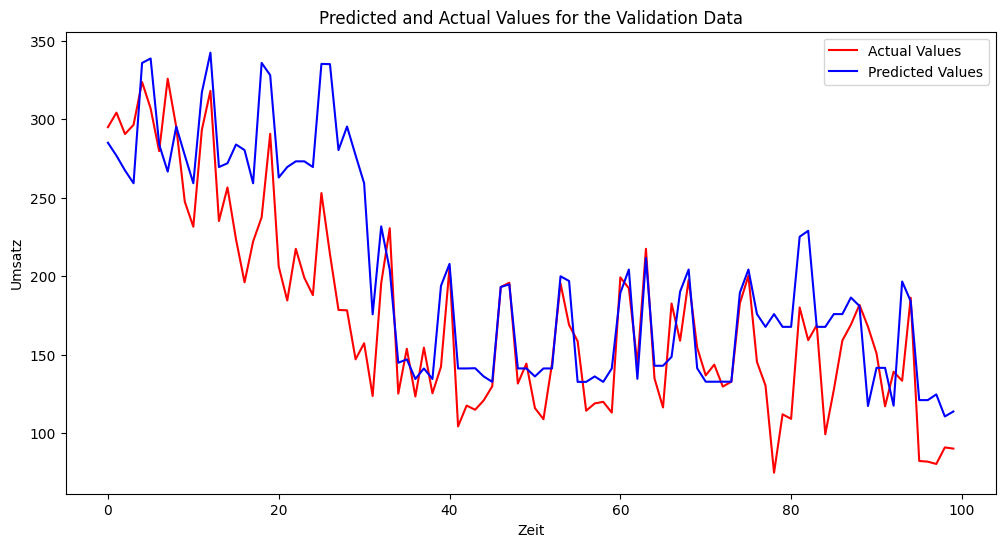

In [10]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

***VORHERSAGE TESTZEITRAUM***

In [11]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Größe des Arrays (shape): (355, 1)


,0
0,290.250488
1,302.168945
2,302.168945
3,363.161133
4,349.595581
...,...
350,261.839722
351,318.007141
352,323.263733
353,236.827560


In [12]:
data_test = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_3"] == 1]
data_test

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/bakery_sales_prediction/0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv'

In [63]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Croissant_Hochladeformat.csv"

predictions_df.to_csv('Croissant_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
